In [1]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random

from keras.models import Sequential
from keras.layers import Dense, Activation

from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython import display

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    f = len(frames)
    a = animation.FuncAnimation(plt.gcf(), animate, frames=f, interval=17)
    display.display(display_animation(a, default_mode='once'))

In [3]:
"""
Environment Parameters
"""
observation_space = 4
action_space = 2
env_name = 'CartPole-v0'
seed = 12

"""
Agent Parameters
"""
episodes = 1000
epsilon_init = 0.25
epsilon_decay = 0.0025
epsilon_min = 0.1
gamma = 0.99

"""
Model Parameters
"""
batch_size = 100
hidden_dims = 10
activation = 'relu'
optim = 'adam'
loss_func = 'mse'

In [4]:
env = gym.make(env_name)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
dqn = Sequential()
dqn.add(Dense(hidden_dims, input_shape=(observation_space,)))
dqn.add(Activation(activation))
dqn.add(Dense(hidden_dims//2))
dqn.add(Activation(activation))
dqn.add(Dense(action_space))
dqn.compile(optimizer=optim, loss=loss_func)

experience_buffer = []

In [6]:
def run_episode(epsilon=0.0, training=False, render=False):
    total_reward = 0
    done = False
    state = np.expand_dims(env.reset(), 0)
    frames = []
    while not done:
        if render:
            frames.append(env.render(mode='rgb_array'))
        if training and random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_values = dqn.predict(state)
            action = np.argmax(q_values)
        next_state, reward, done, _ = env.step(action)
        next_state = np.expand_dims(next_state, 0)
        total_reward += reward
        if training:
            exp_tuple = (state, action, reward, next_state, done)
            experience_buffer.append(exp_tuple)
    epsilon -= epsilon_decay
    epsilon = max(epsilon, epsilon_min)
    train_dqn()
    if render:
        frames.append(env.render(mode='rgb_array'))
        display_frames_as_gif(frames)
    return total_reward, epsilon

In [7]:
def train_dqn():
    batch = random.sample(experience_buffer, batch_size)
    inputs = []
    labels = []
    for sample in batch:
        s, a, r, s_p, d = sample
        inputs.append(s)
        label = dqn.predict(s)
        label[0][a] = r
        if not d:
            label[0][a] += gamma*np.max(dqn.predict(s_p))
        labels.append(label)
    inputs = np.squeeze(np.array(inputs))
    labels = np.squeeze(np.array(labels))
    dqn.fit(inputs, labels, batch_size=batch_size, verbose=0)

In [8]:
for _ in range(50):
    done = False
    state = np.expand_dims(env.reset(), 0)
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        next_state = np.expand_dims(next_state, 0)
        exp_tuple = (state, action, reward, next_state, done)
        experience_buffer.append(exp_tuple)
        state = next_state


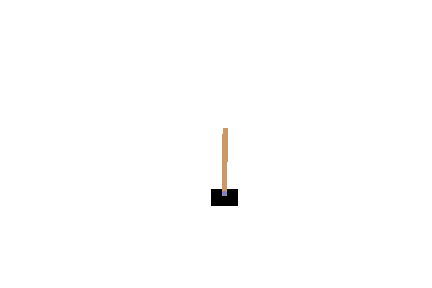
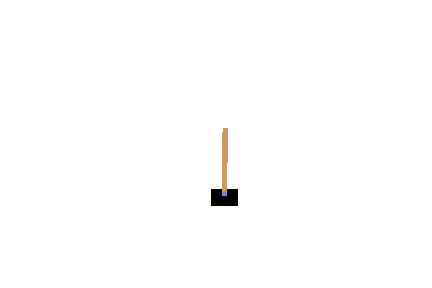
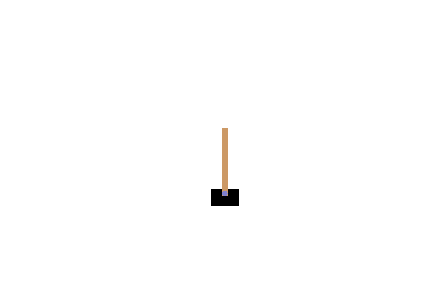
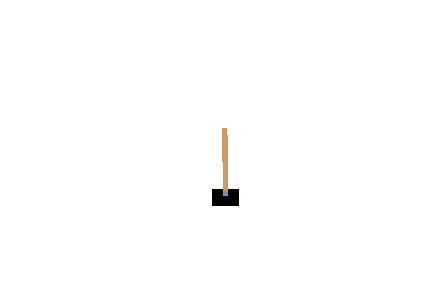
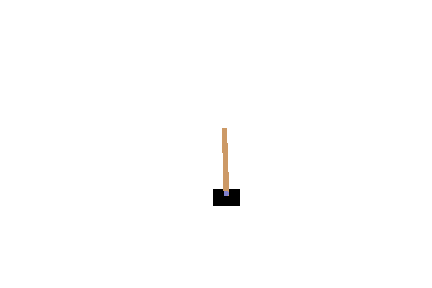
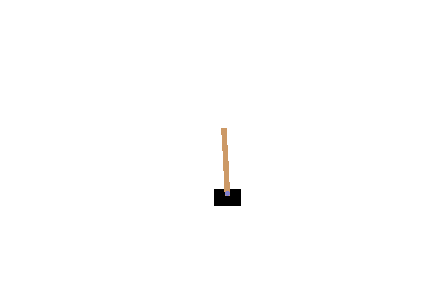
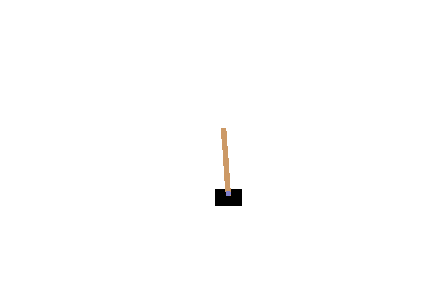
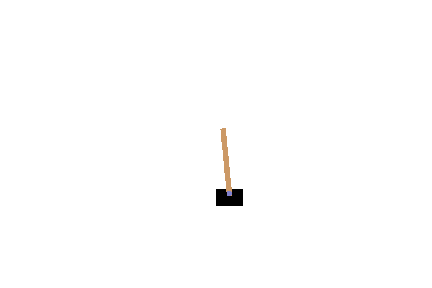
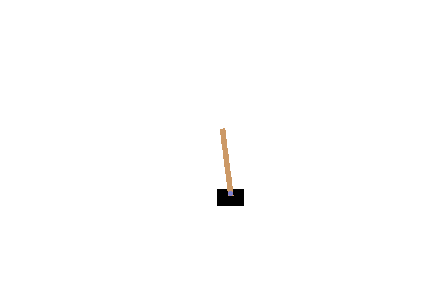
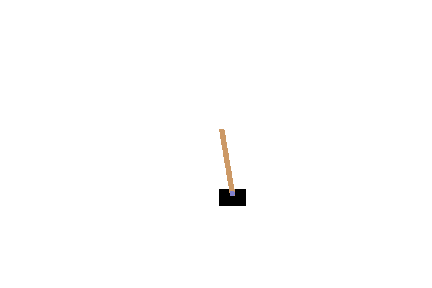
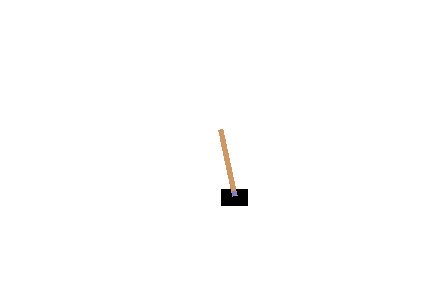
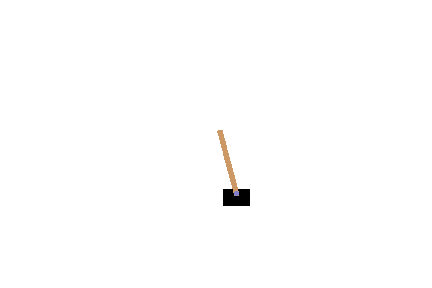


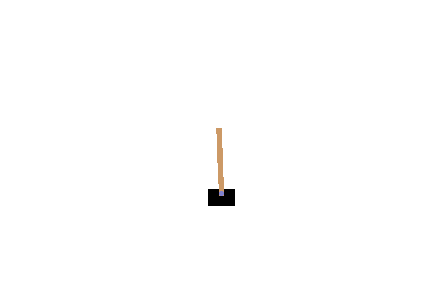
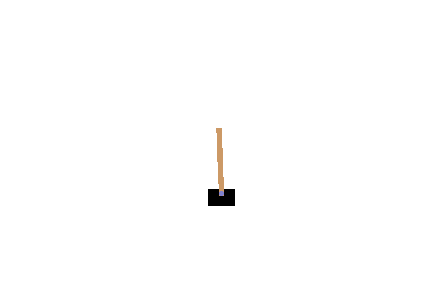
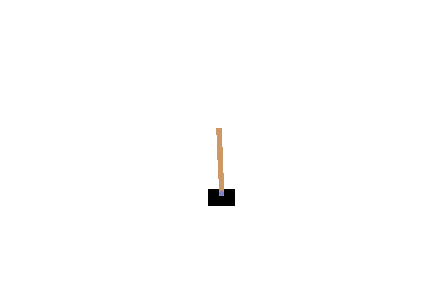
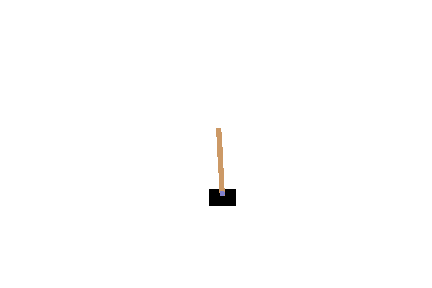
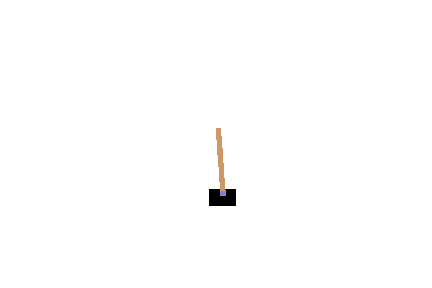
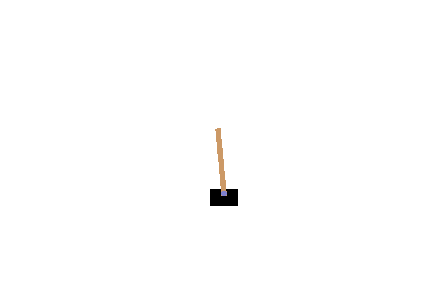
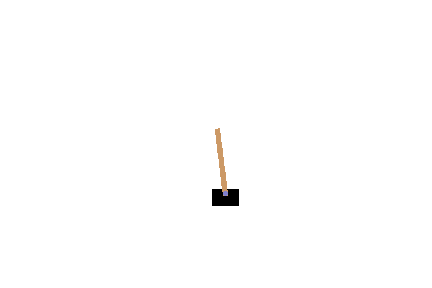
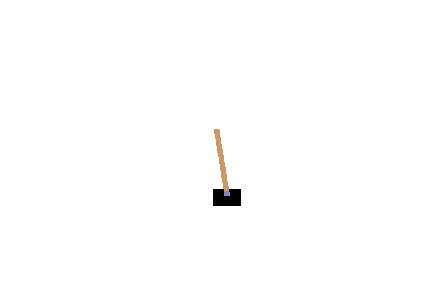
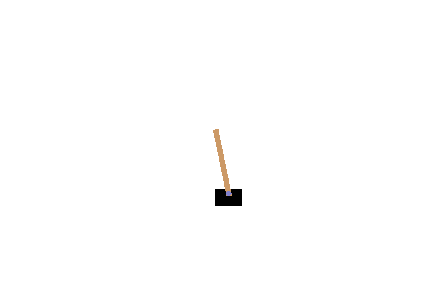
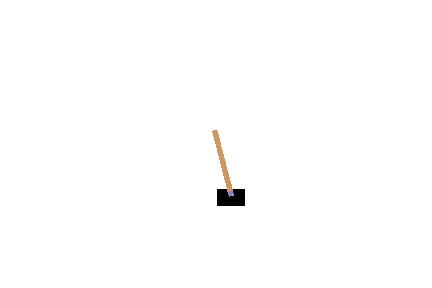

Total reward for episode 5: 9.0



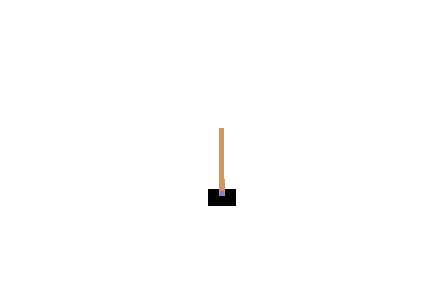
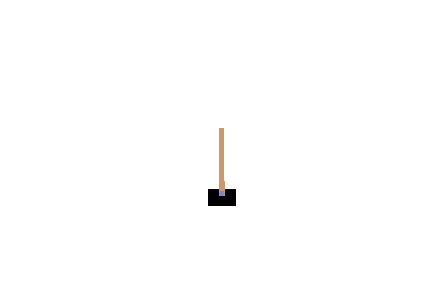
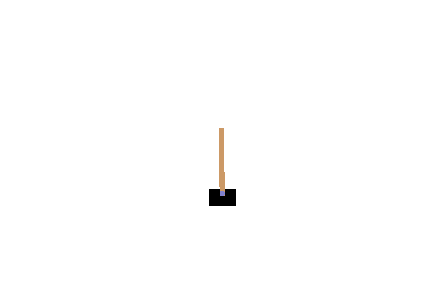
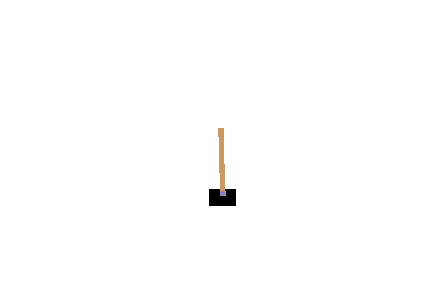
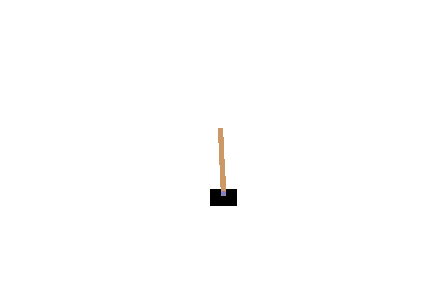
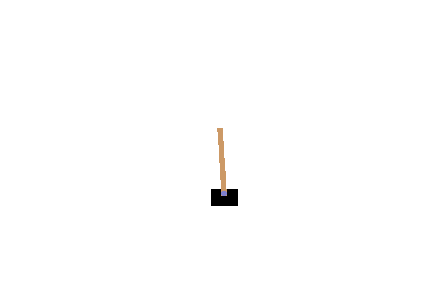
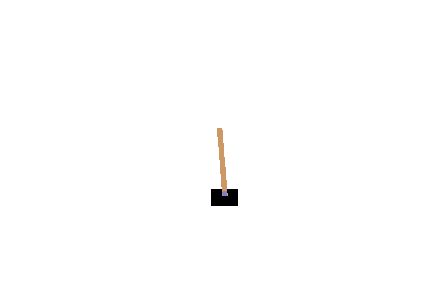
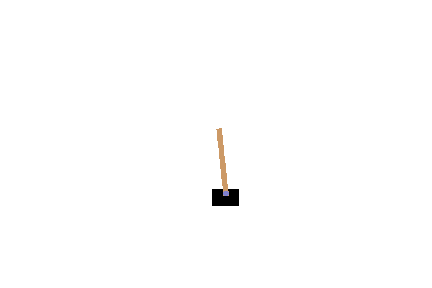
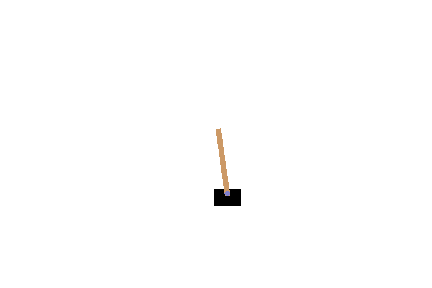
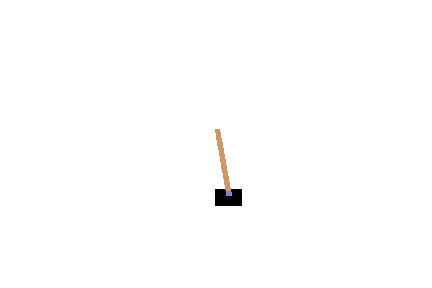
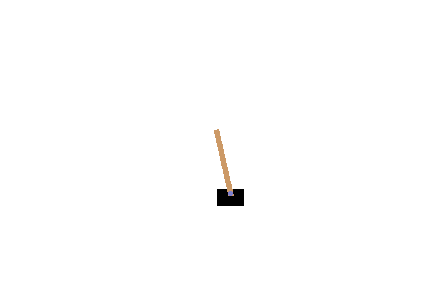

Total reward for episode 10: 10.0
Total reward for episode 15: 10.0



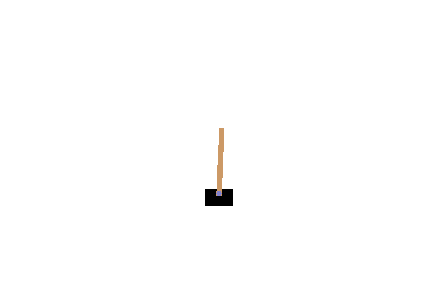
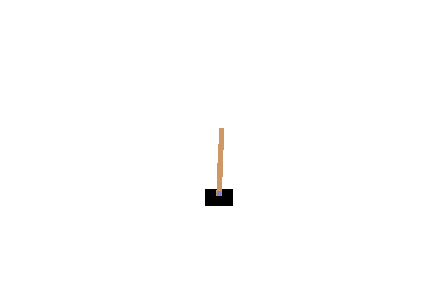
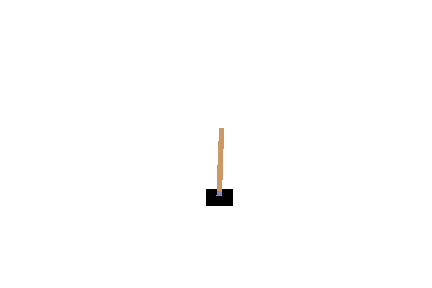
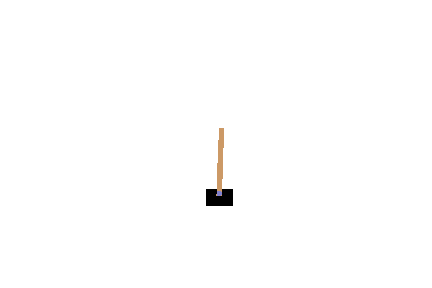
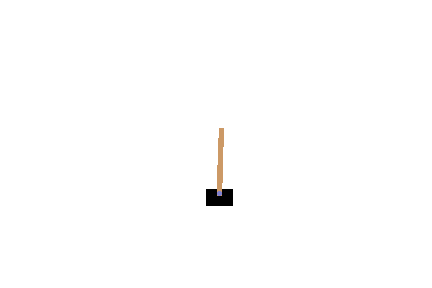
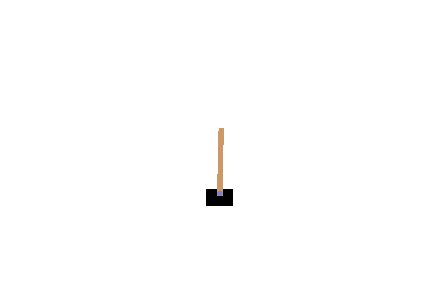
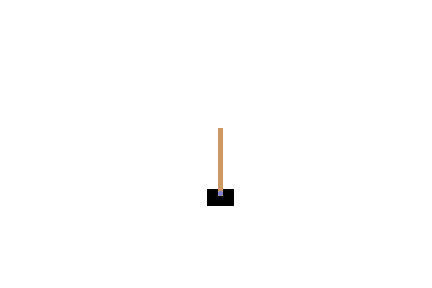
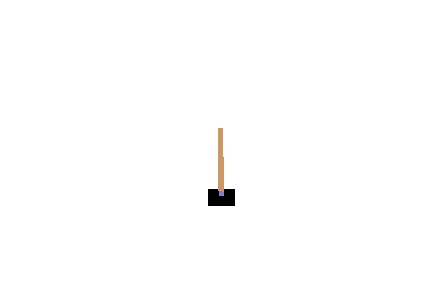
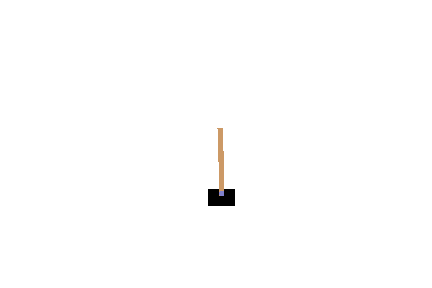
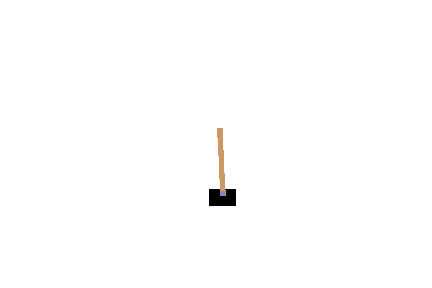
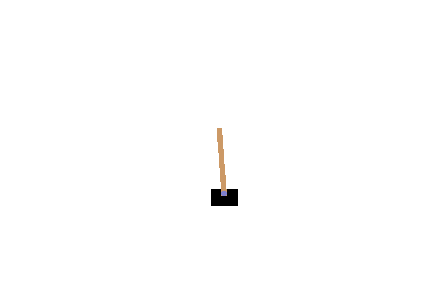
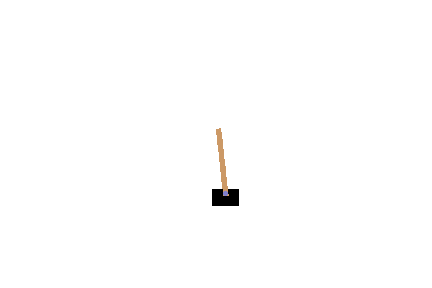
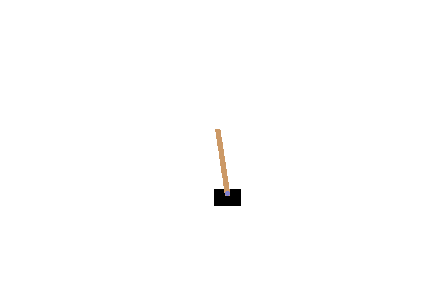
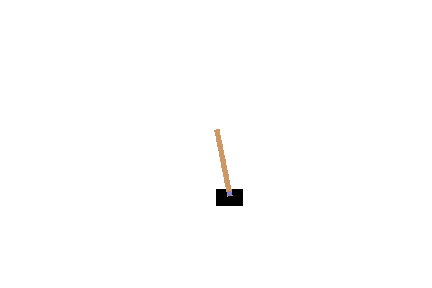
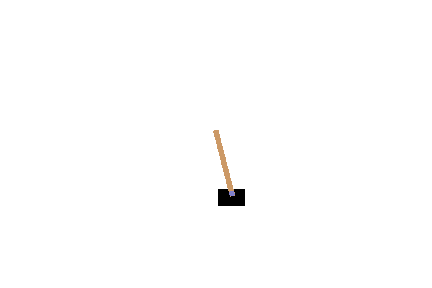

Total reward for episode 20: 14.0
Total reward for episode 25: 11.0
Total reward for episode 30: 9.0
Total reward for episode 35: 13.0
Total reward for episode 40: 9.0
Total reward for episode 45: 9.0



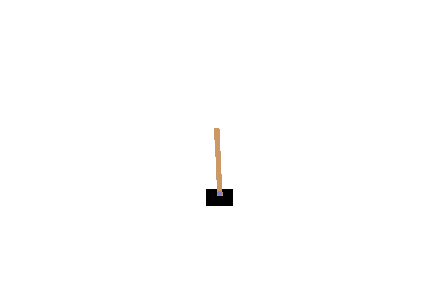
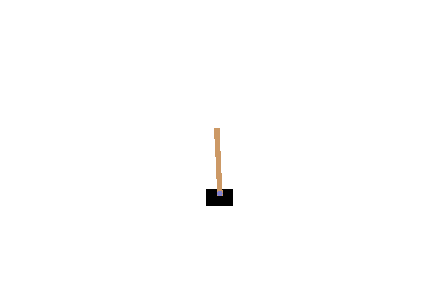
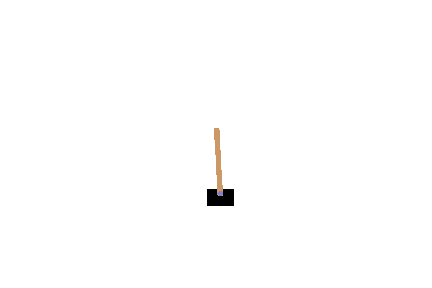
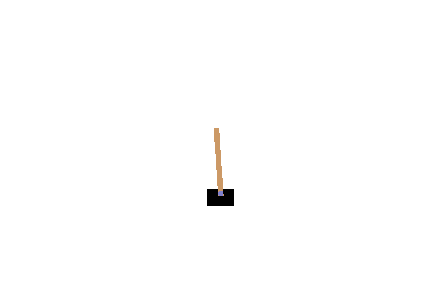
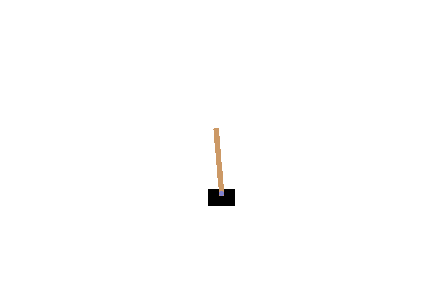
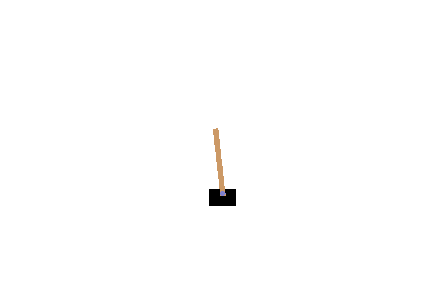
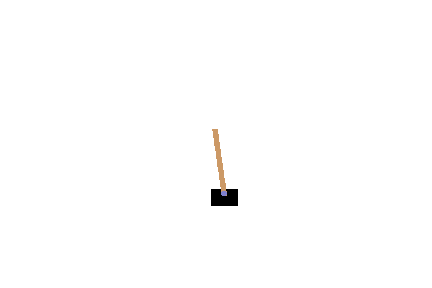
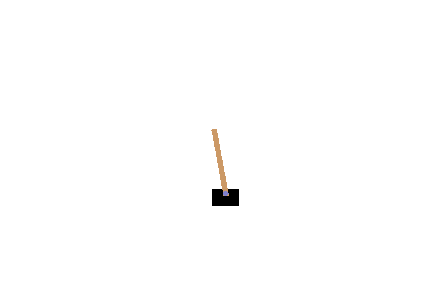
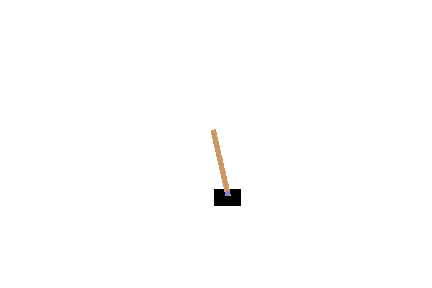

Total reward for episode 50: 8.0
Total reward for episode 55: 10.0
Total reward for episode 60: 11.0
Total reward for episode 65: 8.0
Total reward for episode 70: 10.0
Total reward for episode 75: 8.0
Total reward for episode 80: 10.0
Total reward for episode 85: 9.0
Total reward for episode 90: 10.0
Total reward for episode 95: 11.0



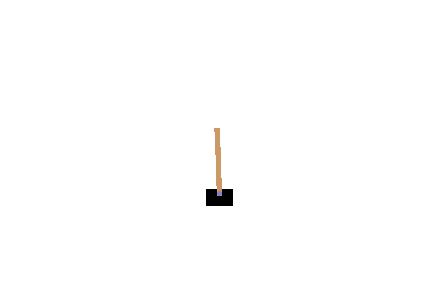
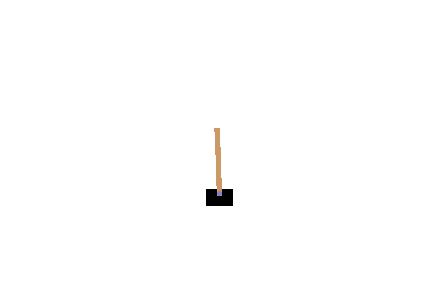
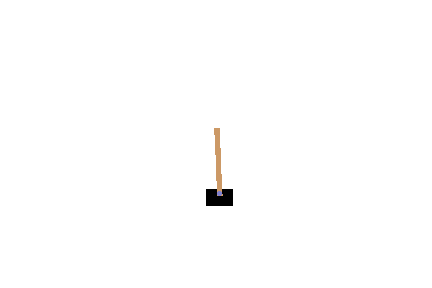
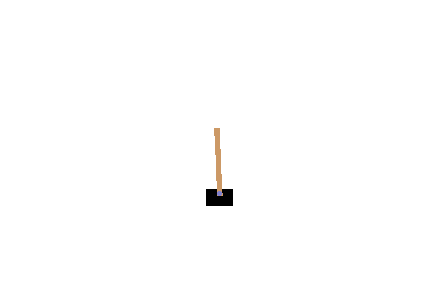
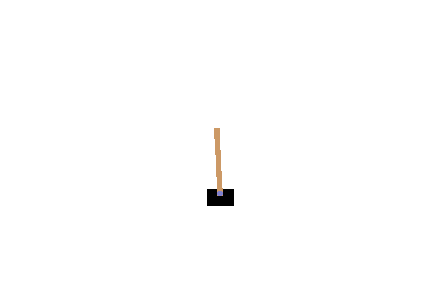
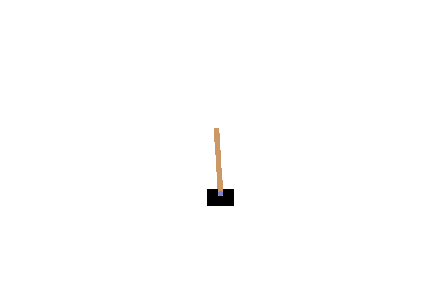
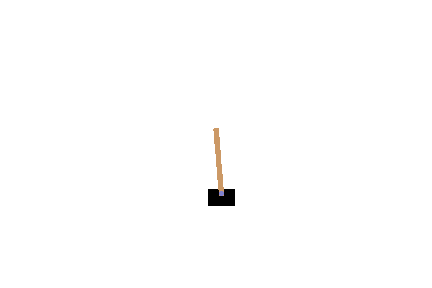
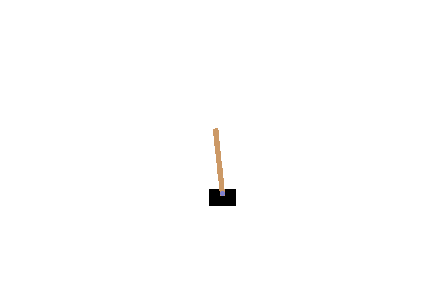
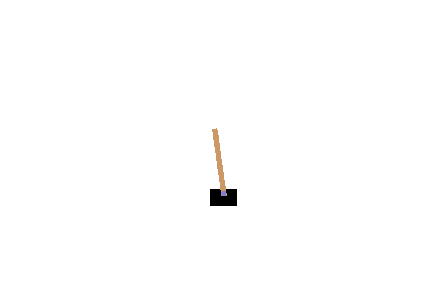
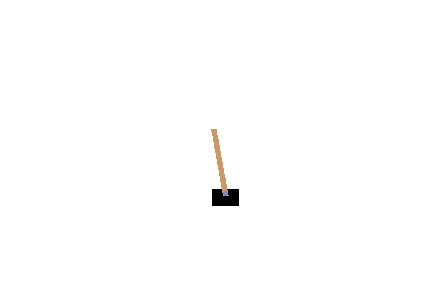
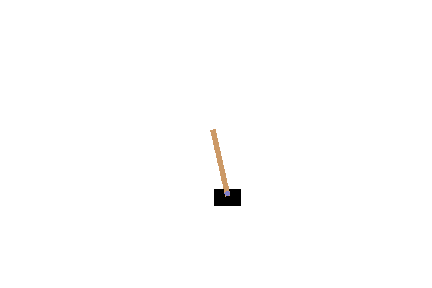

Total reward for episode 100: 10.0
Total reward for episode 105: 11.0
Total reward for episode 110: 9.0
Total reward for episode 115: 8.0
Total reward for episode 120: 10.0
Total reward for episode 125: 11.0
Total reward for episode 130: 11.0
Total reward for episode 135: 10.0
Total reward for episode 140: 8.0
Total reward for episode 145: 10.0
Total reward for episode 150: 9.0
Total reward for episode 155: 10.0
Total reward for episode 160: 10.0
Total reward for episode 165: 9.0
Total reward for episode 170: 10.0
Total reward for episode 175: 10.0
Total reward for episode 180: 9.0
Total reward for episode 185: 10.0
Total reward for episode 190: 8.0
Total reward for episode 195: 12.0
Total reward for episode 200: 9.0
Total reward for episode 205: 9.0
Total reward for episode 210: 9.0
Total reward for episode 215: 10.0
Total reward for episode 220: 9.0
Total reward for episode 225: 10.0
Total reward for episode 230: 9.0
Total reward for episode 235: 10.0
Total reward for episode 240: 9.

In [9]:
render_episodes = [1, 5, 10, 20, 50, 100]
eps = epsilon_init
for episode in range(1, episodes+1):
    rdr = True if episode in render_episodes else False
    tot_reward, eps = run_episode(epsilon=eps, training=True, render=rdr)
    if episode % 5 == 0:
        print(f"Total reward for episode {episode}: {tot_reward}")

In [11]:
eps

0.1